In [1]:
#IMPORT STATEMENTS
import selenium
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import math
import pickle
import random
import copy
import itertools
from dataclasses import dataclass
random.seed(42)
#from basketball_reference_scraper import ask_matches
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup

In [2]:
import os
# assign directory
directory = 'Player_CSV'
 
def true_to_one(input):
    if input:
        return 1
    else:
        return 0

def home_to_one(input):
    if input == "HOME":
        return 1
    else:
        return 0

def win_to_one(input):
    if input == "WIN":
        return 1
    else:
        return 0

def convert_df(dataframe):
    df = dataframe
    df['active'] = df['active'].apply(true_to_one)
    df['location'] = df['location'].apply(home_to_one)
    df['outcome'] = df['outcome'].apply(win_to_one)
    df = df.drop(columns=['date', 'team', 'opponent'])
    return df

X = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        player_df = pd.read_csv(f)
        player_df = convert_df(player_df)
        player_np = player_df.to_numpy()
        player_np = np.transpose(player_np)
        X.append(player_np)
        #print(player_np)
        
#print(X)

In [9]:
from scipy.interpolate import make_interp_spline, BSpline

def tanh(vec):
    vec = np.where(vec < -500, -500, vec)
    vec = np.where(vec > 500, 500, vec)
    ans = (np.exp(vec) - np.exp(-vec))/(np.exp(vec) + np.exp(-vec))
    #print(vec)
    #print(ans)
    return ans

def normalize_all_data(all_input_data):
    return_data = []
    
    for data in all_input_data:
        
        if np.shape(data)[1] == 0:
            continue
        
        mean = np.mean(data, axis = 1, keepdims = True)
        std = np.std(data, axis = 1, keepdims = True)
        
        std = np.where(std == 0, 0.00001, std)
        
        new_data = (data - mean)/std
        
        return_data.append(new_data)
        
    return return_data

def softmax(vec):
    max_vals = np.reshape(np.amax(x, axis = 1), (np.shape(x)[0], 1))
    mod_x = x - max_vals
    
    denominator = np.reshape(np.sum(np.exp(mod_x), axis = 1), (np.shape(x)[0], 1))
    
    return np.exp(mod_x)/denominator
    
def init_weights(features):
    params = {}
    const = 1e0
    
    params["W_aa"] = np.random.randn(features, features) * const
    params["W_ax"] = np.random.randn(features, features) * const
    params["W_y"] = np.random.randn(features, features) * const
    params["b_a"] = np.random.randn(features, 1) * const
    params["b_y"] = np.random.randn(features, 1) * const
    
    return params

def avg_loss_func(predicted_y, actual_y):
    diff = actual_y - predicted_y
    
    loss = 0.05 * np.sum(np.square(diff))
    
    num = np.shape(diff)[1]
    
    return loss/num

def avg_acc_func(predicted, actual_y):
    actual_y[actual_y == 0] = 1
    diff = abs(predicted - actual_y)
    perc_diff = diff/(actual_y)
    
    perc_diff = np.where(perc_diff > 1e2, 100, perc_diff)
    perc_diff = np.where(perc_diff < -1e2, -100, perc_diff)
    
    #print(diff)
    #print(actual_y)
    #print(perc_diff)
    
    #print(np.shape(actual_y))
    
    num = np.shape(diff)[1]
    
    total_avg_acc = np.sum(perc_diff)/num
    
    return total_avg_acc
    
def rnn_forward_prop(input_data, params):
    
    features = np.shape(input_data)[0]
    examples = np.shape(input_data)[1]
    
    actual_y = input_data[:]
    #print(np.shape(actual_y))
    actual_y_row = np.shape(actual_y)[0]
    actual_y_col = np.shape(actual_y)[1]
    
    W_aa = params["W_aa"]
    W_ax = params["W_ax"]
    b_a = params["b_a"]
    W_y = params["W_y"]
    b_y = params["b_y"]
        
    a_last = np.random.randn(features, 1) * 0.01
    
    cache_a = [a_last]
    cache_x = []
    
    predictions = np.array([])
    
    for example in range(examples):
        #print(a_last)
        x_curr = input_data[:, 0]
        x_curr = np.reshape(x_curr, (features, 1))
        
        #print(a_last)
        #print(x_curr)
        #print(b_a)
        
        z_a_new = np.dot(W_aa, a_last) + np.dot(W_ax, x_curr) + b_a
        
        #print(np.shape(z_a_new))
        
        a_new = tanh(z_a_new)
        y_new = np.dot(W_y, a_new) + b_y
        
        #print(np.shape(y_new))
        #print(a_new)
        
        #print(z_a_new)
        
        predictions = np.append(predictions, y_new)
        
        a_last = np.copy(a_new)
        
        cache_a.append(a_last)
        cache_x.append(x_curr)
        
    predictions = np.reshape(predictions, (actual_y_row, actual_y_col))
    
    loss = avg_loss_func(predictions, actual_y)
    
    avg_acc = avg_acc_func(predictions, actual_y)
    #print(loss)
    #print(avg_acc)
    return predictions, actual_y, cache_a, cache_x, loss, avg_acc

def rnn_backward_prop(predictions, actual_y_vals, params, cache_a, cache_x):
    grads = {}
    
    num = np.shape(predictions)[1]
    
    for param, np_arr in params.items():
        dim = np.shape(np_arr)
        grads[param] = np.zeros(dim)
    
    da_future = np.zeros((np.shape(predictions[:, 0])[0], 1))
    
    for i in range(num, 0, -1):
        y_actual = actual_y_vals[:, i-1]
        y_hat = predictions[:, i-1]
        x_i = cache_x[i-1]
        a_i = cache_a[i]
        a_i_last = cache_a[i-1]
        
        dy = y_hat - y_actual
        dy = np.reshape(dy, (np.shape(dy)[0], 1))
        #print(dy)
        da = np.dot(params["W_y"].T, dy)
        dz = da * (1 + a_i) * (1 - a_i)
        dz_future = da_future * (1 + a_i) * (1 - a_i)
         
        d_by = np.sum(dy, axis = 1, keepdims = True)
        d_Wy = np.dot(dy, a_i.T)
        
        d_ba = np.sum(dz, axis = 1, keepdims = True)
        d_Waa = np.dot(dz + dz_future, a_i_last.T)
        d_Wax = np.dot(dz + dz_future, x_i.T)
        
        da_future = np.copy(da)
        
        grads["b_y"] += d_by
        grads["W_y"] += d_Wy
        grads["b_a"] += d_ba
        grads["W_aa"] += d_Waa
        grads["W_ax"] += d_Wax
        
    return grads

def update_params(predictions, actual_y_vals, params, cache_a, cache_x, step_size = 1e-3):
    grads = rnn_backward_prop(predictions, actual_y_vals, params, cache_a, cache_x)
    #print(grads)
    for param in params.keys():
        params[param] = params[param] - step_size * grads[param]
    
    #print(params)
    return params
    
def train_test_split(all_input_data, perc_train = 0.8):
    num_examples = len(all_input_data)
    
    train_examples = int((perc_train * num_examples) // 1)
    print(train_examples)
    test_examples = num_examples - train_examples
    
    all_train_data = all_input_data[:train_examples]
    all_test_data = all_input_data[train_examples:]
    
    return all_train_data, all_test_data

def rnn(all_input_data):
    all_train_data, all_test_data = train_test_split(all_input_data, 0.8)
    
    features = np.shape(all_train_data[0])[0]
    params = init_weights(features)
    
    loss_arr = np.array([])
    avg_acc_arr = np.array([])
    
    discount_games = 0
    for epoch in range(1):
        for example_num, train_example in enumerate(all_train_data):
            games = np.shape(train_example)[1]

            if games == 0:
                discount_games += 1
                continue

            predictions, actual_y, cache_a, cache_x, loss, avg_acc = rnn_forward_prop(train_example, params)
            params = update_params(predictions, actual_y, params, cache_a, cache_x)
            #if example_num < 100:
            #    print(loss)

            loss_arr = np.append(loss_arr, loss)
            avg_acc_arr = np.append(avg_acc_arr, avg_acc)
    
    #print(discount_games)
    #print(len(all_train_data))
    #print(np.shape(loss_arr))
    #print(np.shape(avg_acc_arr))
    x_amount = len(all_train_data) - discount_games
    x_axis = np.arange(len(loss_arr))
    #print(x_axis)
    
    
    x_axis_new = np.linspace(x_axis.min(), x_axis.max(), 200) 

    #define spline
    spl = make_interp_spline(x_axis, loss_arr, k=1)
    loss_smooth = spl(x_axis_new)

    
    plt.clf()
    plt.plot(x_axis_new, loss_smooth)
    plt.title("Average loss over training examples")
    plt.show()
    
    #plt.clf()
    #plt.plot(x_axis, avg_acc_arr)
    #plt.title("Average Inaccuracy over training examples")
    #plt.show()
    
    test_loss_arr = np.array([])
    test_avg_acc = np.array([])
    
    for example_num, test_example in enumerate(all_test_data):
        games = np.shape(test_example)[1]

        if games == 0:
            discount_games += 1
            continue

        predictions, actual_y, cache_a, cache_x, loss, avg_acc = rnn_forward_prop(test_example, params)
        params = update_params(predictions, actual_y, params, cache_a, cache_x)
        #if example_num < 100:
        #    print(loss)

        test_loss_arr = np.append(test_loss_arr, loss)
        test_avg_acc = np.append(test_avg_acc, avg_acc)
    
    print("Average Loss (Test): " + str(np.mean(test_loss_arr)) + "")
    print("Average Inaccuracy (Test): " + str(np.mean(test_avg_acc)) + "%")
    
    #print(loss_arr)
    #print(avg_acc_arr)
    

7246


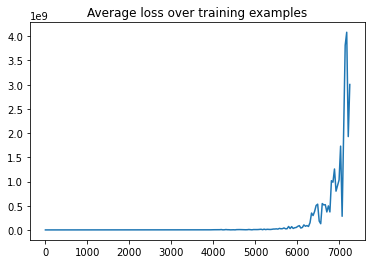

Average Loss (Test): 12351505206.431122
Average Inaccuracy (Test): -112.0304697452788%


In [10]:
test_input = normalize_all_data(X)
#print(test_input)
rnn(test_input)